In [ ]:
!pip install py7zr
!pip install tensorflow==2.4.0

In [ ]:
from pandas import DataFrame, read_csv, get_dummies, Series, concat
from pathlib import Path
from numpy import array, random, eye, argmax
import numpy as np
import pickle
import py7zr
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import TensorBoard, Callback, ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.layers.core import Dropout
from sklearn.metrics import  confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from os.path import split
from random import shuffle
from shutil import rmtree
import random
import glob
from re import findall

In [ ]:
path_to_source_folder = '/content/drive/MyDrive/handmask/onionfixed.zip'
model_out = Path('/content/drive/MyDrive/onion_model')
batch_size = 100
ACCURACY_THRESHOLD = 0.95
split_ratio = 0.2       #training validation split

# EXTRACTING ZIP

In [ ]:
make_dir = Path('/content/ASLdataset')
if make_dir.exists(): rmtree(make_dir)
make_dir.mkdir()

if findall('.7z', str(path_to_source_folder)):
    with py7zr.SevenZipFile(path_to_source_folder, mode='r') as z:
        z.extractall('/content/ASLdataset')
    path_to_source_folder = Path('/content/ASLdataset/csv')
elif findall('.zip', str(path_to_source_folder)):
    !unzip $path_to_source_folder -d /content/ASLdataset
    path_to_source_folder = Path('/content/ASLdataset/csv')
else:
    path_to_source_folder = Path(path_to_source_folder)

# Initializing variables

In [ ]:
model_name = model_out / 'ADB_9_95'
path_to_source_folder = Path('/content/ASLdataset/content/newfiles')
source_directory = path_to_source_folder
y = []
x = []
f = []
e = []
all_source_ds =[]
x_valid =[]
y_valid = []
f_valid =[]
failed_final_check =[]

# Checking for classes in the *source_directory*

In [ ]:
classes = sorted(list(x.name for x in source_directory.glob('*')))
if any('.ipynb_checkpoints' in s for s in classes):
    classes.remove('.ipynb_checkpoints')
print(classes)
# klasses = ['Address', 'Movie', 'Name', 'Phone', 'Play', 'Please','Work','Your']
# klasses = ['What', 'You', 'When', 'Where']
# classes = klasses
# print(classes)

['Age', 'Bird', 'Favourite']


# Splitting validation and training data 

In [ ]:
for category in classes:
    cat_dir = list((source_directory/category).glob("*"))
    all_source_ds.append(cat_dir)
print(all_source_ds)
all_source_ds_flat = [item for sublist in all_source_ds for item in sublist]
shuffle(all_source_ds_flat)
print(len(all_source_ds_flat))
valid_csv_list = all_source_ds_flat[:int(len(all_source_ds_flat)*split_ratio)]
train_csv_list = all_source_ds_flat[int(len(all_source_ds_flat)*split_ratio):]
print(all_source_ds_flat)
print(len(all_source_ds_flat))

[[PosixPath('/content/ASLdataset/content/newfiles/Age/Age_86.csv'), PosixPath('/content/ASLdataset/content/newfiles/Age/Age_13.csv'), PosixPath('/content/ASLdataset/content/newfiles/Age/Age_73.csv'), PosixPath('/content/ASLdataset/content/newfiles/Age/Age_81.csv'), PosixPath('/content/ASLdataset/content/newfiles/Age/Age_66.csv'), PosixPath('/content/ASLdataset/content/newfiles/Age/Age_36.csv'), PosixPath('/content/ASLdataset/content/newfiles/Age/Age_49.csv'), PosixPath('/content/ASLdataset/content/newfiles/Age/Age_38.csv'), PosixPath('/content/ASLdataset/content/newfiles/Age/Age_80.csv'), PosixPath('/content/ASLdataset/content/newfiles/Age/Age_20.csv'), PosixPath('/content/ASLdataset/content/newfiles/Age/Age_3.csv'), PosixPath('/content/ASLdataset/content/newfiles/Age/Age_8.csv'), PosixPath('/content/ASLdataset/content/newfiles/Age/Age_47.csv'), PosixPath('/content/ASLdataset/content/newfiles/Age/Age_16.csv'), PosixPath('/content/ASLdataset/content/newfiles/Age/Age_99.csv'), PosixPath(

# Reading Validation Data

In [ ]:
for csv in valid_csv_list:
    d = read_csv(str(csv), header=None ).values
    if d.shape == (480,640):
            #random_number = random.randint(1,20)
            x_valid.append(d)
            label = split(split(csv)[0])[1]
            print(csv,"  ", label)
            y_valid.append(label)
    else:
            f_valid.append(d)
            print(d.shape)

/content/ASLdataset/content/newfiles/Age/Age_66.csv    Age
/content/ASLdataset/content/newfiles/Bird/Bird_92.csv    Bird
/content/ASLdataset/content/newfiles/Favourite/Favourite_49.csv    Favourite
/content/ASLdataset/content/newfiles/Favourite/Favourite_40.csv    Favourite
/content/ASLdataset/content/newfiles/Bird/Bird_33.csv    Bird
/content/ASLdataset/content/newfiles/Age/Age_8.csv    Age
/content/ASLdataset/content/newfiles/Age/Age_58.csv    Age
/content/ASLdataset/content/newfiles/Bird/Bird_7.csv    Bird
/content/ASLdataset/content/newfiles/Age/Age_69.csv    Age
/content/ASLdataset/content/newfiles/Favourite/Favourite_53.csv    Favourite
/content/ASLdataset/content/newfiles/Bird/Bird_73.csv    Bird
/content/ASLdataset/content/newfiles/Age/Age_67.csv    Age
/content/ASLdataset/content/newfiles/Bird/Bird_6.csv    Bird
/content/ASLdataset/content/newfiles/Favourite/Favourite_90.csv    Favourite
/content/ASLdataset/content/newfiles/Favourite/Favourite_71.csv    Favourite
/content/ASLd

# Saving Variables

In [ ]:
with open(str(model_out)+'/finalcsvx_valid.pkle','wb') as xyz:
    pickle.dump(x_valid,xyz)
with open(str(model_out)+'/finalcsvy_valid.pkle','wb') as xyz:
    pickle.dump(y_valid,xyz)
with open(str(model_out)+'/finaltrain_csv_list.pkle','wb') as xyz:
    pickle.dump(train_csv_list,xyz)
with open(str(model_out)+'/finalvalid_csv_list.pkle','wb') as xyz:
    pickle.dump(valid_csv_list,xyz)
    

# Loading variables

In [ ]:
with open(str(model_out)+'/finalcsvx_valid.pkle','rb') as xyz:
    x_valid = pickle.load(xyz)
with open(str(model_out)+'/finalcsvy_valid.pkle','rb') as xyz:
    y_valid = pickle.load(xyz)
with open(str(model_out)+'/finaltrain_csv_list.pkle','rb') as xyz:
    train_csv_list = pickle.load(xyz)
with open(str(model_out)+'/finalvalid_csv_list.pkle','rb') as xyz:
    valid_csv_list = pickle.load(xyz)
print(train_csv_list)
shuffle(train_csv_list)
print(train_csv_list)

[PosixPath('/content/ASLdataset/content/newfiles/Favourite/Favourite_52.csv'), PosixPath('/content/ASLdataset/content/newfiles/Age/Age_56.csv'), PosixPath('/content/ASLdataset/content/newfiles/Age/Age_7.csv'), PosixPath('/content/ASLdataset/content/newfiles/Age/Age_53.csv'), PosixPath('/content/ASLdataset/content/newfiles/Favourite/Favourite_49.csv'), PosixPath('/content/ASLdataset/content/newfiles/Age/Age_54.csv'), PosixPath('/content/ASLdataset/content/newfiles/Bird/Bird_14.csv'), PosixPath('/content/ASLdataset/content/newfiles/Bird/Bird_10.csv'), PosixPath('/content/ASLdataset/content/newfiles/Bird/Bird_12.csv'), PosixPath('/content/ASLdataset/content/newfiles/Bird/Bird_97.csv'), PosixPath('/content/ASLdataset/content/newfiles/Favourite/Favourite_37.csv'), PosixPath('/content/ASLdataset/content/newfiles/Favourite/Favourite_82.csv'), PosixPath('/content/ASLdataset/content/newfiles/Favourite/Favourite_88.csv'), PosixPath('/content/ASLdataset/content/newfiles/Favourite/Favourite_94.csv

In [ ]:
print(x_valid[1])
print(y_valid)
print(train_csv_list)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
['Age', 'Favourite', 'Bird', 'Bird', 'Favourite', 'Bird', 'Age', 'Bird', 'Age', 'Bird', 'Age', 'Favourite', 'Favourite', 'Bird', 'Bird', 'Age', 'Age', 'Favourite', 'Favourite', 'Favourite', 'Favourite', 'Bird', 'Favourite', 'Favourite', 'Bird', 'Favourite', 'Age', 'Favourite', 'Favourite', 'Bird', 'Favourite', 'Age', 'Age', 'Favourite', 'Age', 'Age', 'Age', 'Age', 'Bird', 'Age', 'Bird', 'Age', 'Favourite', 'Favourite', 'Favourite', 'Favourite', 'Favourite', 'Bird', 'Age', 'Bird', 'Age', 'Favourite', 'Bird', 'Favourite', 'Age', 'Favourite', 'Favourite', 'Favourite', 'Age', 'Favourite']
[PosixPath('/content/ASLdataset/content/newfiles/Age/Age_99.csv'), PosixPath('/content/ASLdataset/content/newfiles/Age/Age_83.csv'), PosixPath('/content/ASLdataset/content/newfiles/Age/Age_10.csv'), PosixPath('/content/ASLdataset/content/newfiles/Age/A

# Converting x_valid list to dataframe and y_valid list to one hot vector style

In [ ]:
print(len(x_valid))

60


In [ ]:

df = DataFrame({'cat': classes})
dummies = get_dummies(df,prefix='', prefix_sep='')
y_valid = dummies.T.reindex(y_valid).fillna(0).values
x_valid = array(x_valid)
x_valid = x_valid.reshape(480,640,1)
print(x_valid[1])
print(y_valid)
print(train_csv_list)

ValueError: ignored

In [ ]:
print(x_valid[0][0][0])

[0.]


# Final check for variables before training

In [ ]:
print('length of y_valid = ' ,y_valid.shape[1])
print('y_valid example = ' ,y_valid[1])
print('shape of x_valid = ', x_valid.shape[1:])
print('length of training data = ', len(train_csv_list))
print('Model will be saved here : ', model_out)

length of y_valid =  3
y_valid example =  [0 0 1]
shape of x_valid =  (480, 640, 1)
length of training data =  240
Model will be saved here :  /content/drive/MyDrive/onion_model


In [ ]:
x_valid[0].dtype

dtype('float64')

# logs file location set 

In [ ]:
import csv 
csv_name = model_out / "logs.csv"
if not csv_name.exists():
    with open(csv_name, 'w') as csvfile:
        csvwriter = csv.writer(csvfile) 
        csvwriter.writerow(['count','accuracy','val_accuracy','loss','val_loss'])

# Generator and callback

In [ ]:
import tensorflow as tf
def custom_generator(csv_list, batch_size):
    i = 0
    while True:
        batch = {'csv': [], 'labels': []}
        b = 0
        while b < batch_size:
        # for b in range(batch_size):
            # print(len(csv_list))
            if i == (int(len(csv_list))):
                shuffle(csv_list)
                i=0
            # Read data from csv using the name from csv_list
            csv_path = csv_list[i]
            label = split(split(csv_path)[0])[1]

            d = read_csv(str("/" + str(csv_path)), header=None ).values
            if d.shape == (480,640):
                random_number = random.randint(1,20)
                
                batch['csv'].append(d)
                batch['labels'].append(label)
                b+=1
            else:
                # print(csv_path,"  ",d.shape)
                failed_final_check.append(csv_path)
            i += 1
        batch['csv'] = array(batch['csv'])
        batch['csv'] = batch['csv'].reshape(len(batch['csv']),480,640,1)
        # Convert labels to categorical values
        df = DataFrame({'cat': classes})
        dummies = get_dummies(df,prefix='', prefix_sep='')
        batch['labels'] = dummies.T.reindex(batch['labels']).fillna(0).values
        # batch['labels'] = eye(len(classes))[batch['labels']]
        # print (batch['labels'],batch['csv'])
        # print("hello")
        # print(type(batch['csv']),type(batch['labels']))
        yield tuple([batch['csv'], batch['labels']])

In [ ]:
start_count = 1
class stop_(Callback): 
    def on_epoch_end(self, epoch, logs={}):
        epoch_count = epoch + start_count
        model.save(Path(str(model_out) + "/model" + str(epoch_count)))
        CSVLogger(str(model_out) + "/model_history_log.csv", append=True)
        with open(csv_name, 'a+') as csvfile:
            csvwriter = csv.writer(csvfile) 
            csvwriter.writerow([epoch_count,logs.get('accuracy'),logs.get('val_accuracy'),logs.get('loss'),logs.get('val_loss')])
        if(logs.get('accuracy') > ACCURACY_THRESHOLD):
                print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
                self.model.stop_training = True
stop_training = stop_()     

# Model structure

In [ ]:
from tensorflow.keras.layers import LSTM, Dense



In [ ]:

model=Sequential([])

#convulation layer 1
model.add(Conv2D(64,(3,3),activation="relu",input_shape=(480,640,1)))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

#convulation layer 2
model.add(Conv2D(128,(3,3),activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(3,activation="softmax"))




In [ ]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(640)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(128, return_sequences=False, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu',trainable=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

TypeError: ignored

# Transfer learning

In [ ]:
old_model = load_model('/content/drive/MyDrive/Model/ADB_9_95')

In [ ]:
# hidden = Dense(120, activation='relu')(model.layers[-2].output). model.layers[-1].output

In [ ]:
model_reduced = Sequential()
for layer in old_model.layers[:-1]:
    model_reduced.add(layer)
model_reduced.summary()

In [ ]:
model = Sequential()
model.add(model_reduced)
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='softmax'))
model.summary()

# Only run when want to resume training from last checkpoint

In [ ]:
model = load_model('/content/drive/MyDrive/30frame_20classmodel/model67')    #load the last checkpoint file

# Training

In [ ]:
a = Adam(learning_rate=0.00001)
# H = model.compile(optimizer=a, loss='categorical_crossentropy', metrics=['accuracy'])

H = model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])
# class_weight = {0: 1.,      #Address
#                 1: 1.,      #Movie
#                 2: 1.,      #Name
#                 3: 1.,      #Phone
#                 4: 1.,      #Play
#                 5: 1.,      #Please
#                 6: 1.,      #Work
#                 7: 1.   }   #Your
# class_weight = {0: 1.,      
#                 1: 1.,      
#                 2: 1.,      
#                 3: 1.     } 
history = model.fit_generator(custom_generator(train_csv_list,batch_size), steps_per_epoch=len(train_csv_list)//(batch_size), epochs=1000, verbose=1,  callbacks=[stop_training], validation_data=(x_valid,y_valid) )

print('Saving model')
model.save(Path(str(model_out) + "/ADB"))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/1000


In [ ]:
a = Adam(learning_rate=0.00001)
H = model.compile(optimizer=a, loss='categorical_crossentropy', metrics=['accuracy'])
# class_weight = {0: 1.,      #Address
#                 1: 1.,      #Movie
#                 2: 1.,      #Name
#                 3: 1.,      #Phone
#                 4: 1.,      #Play
#                 5: 1.,      #Please
#                 6: 1.,      #Work
#                 7: 1.   }   #Your
# class_weight = {0: 1.,      
#                 1: 1.,      
#                 2: 1.,      
#                 3: 1.     } 
history = model.fit_generator(custom_generator(train_csv_list,batch_size), steps_per_epoch=len(train_csv_list)//(batch_size), epochs=1000, verbose=1,  callbacks=[stop_training], validation_data=(x_valid,y_valid))

print('Saving model')
model.save(Path(str(model_out) + "/ADB"))

Batch size calculator

In [ ]:
print(len(train_csv_list)//batch_size)
steps_per_epoch= len(train_csv_list)//(batch_size)
print (steps_per_epoch)

336
336


# Training accuracy, validation accuracy, loss, validation loss plot from *logs.csv*

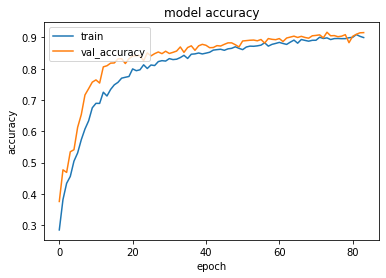

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

history = pd.read_csv('/content/drive/MyDrive/20frame_4classmodel/logs.csv')
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val_accuracy'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val'], loc='upper left')
plt.show()

# Testing model

In [ ]:
predictions = model.predict(x_valid)
predictions = argmax(predictions, axis=1)
y_true = argmax(y_valid, axis=1)
cm = confusion_matrix(y_true, predictions,labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Play', 'Work', 'Your', 'Address', 'Name', 'please', 'Phone', 'Movie'])
disp.plot()

# old read all files method

In [ ]:
# db = Path('/content/drive/MyDrive/ASL dataset/Generator model files')
# selected_db = db
# all_source_ds = []      #source video location list
# for klass in list(selected_db.glob('*')):
#     print(klass.name)
    
#     for csv in klass.glob('*'):
#         print(csv)
#         d = read_csv(str(csv), header=None ).values
#         if d.shape == (50,1629):
#              e.append(d)
#              y.append(klass.name)
#         else:
#              f.append(d)
#         print(d.shape)

# Validation avi name to csv name

In [ ]:
# import os
# new_train_csv_list =[]
# for item in train_csv_list:      
#     csv_path = item
#     path = os.path.normpath(csv_path)
#     new_train_csv_list.append(Path(os.path.join(*path.split(os.sep)[:2],*path.split(os.sep)[4:])))
# print(new_train_csv_list)
# with open('/content/finaltrain_csv_list.pkle','wb') as xyz:
#     pickle.dump(new_train_csv_list,xyz)

# Save best checkpoint only method callback

In [ ]:
# model_checkpoint_callback  = ModelCheckpoint(filepath = model_out / 'model-{epoch:03d}-{accuracy:03f}.ckpt', verbose=1 , monitor='accuracy', mode='auto', save_best_only=True )

# Random code tests

In [ ]:
import re
from pathlib import Path
source_directory = Path('/content/drive/MyDrive/20frame_8classmodel')

start_count =[]
model_files = list(x.name for x in source_directory.glob('*'))
print(model_files)
for item in model_files:
    s = (re.findall("\d+$",item))
    s = int(s[0]) if s else -1,item
print(max(s))

In [ ]:
def extract_number(f):
    s = re.findall("\d+$",f)
    s = (int(s[0]) if s else -1,f)
    print(s)
    s = re.findall("\d+$",s)
    return int(s[0])

model_files = list(x.name for x in source_directory.glob('*'))
start_count = max(model_files,key=extract_number)
print (start_count)